## 1. Searching for news headlines inside HTML files


In [1]:
# Import libraries
from bs4 import BeautifulSoup
import os
from urllib.request import Request, urlopen

html_tables = {}

url = {"https://finviz.com/quote.ashx?t=META&p=d", 
       "https://finviz.com/quote.ashx?t=GOOGL&ty=c&ta=1&p=d"}
for link in url:
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = Request(link ,headers=hdr)
    page = urlopen(req)

    html = BeautifulSoup(page)
    
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')

    html_tables[html.title.get_text().split(" ")[0]] = html_table

## 2. Observe some webpage contents

In [2]:
meta = html_tables['META']
meta_tr = meta.findAll('tr')

for i, table_row in enumerate(meta_tr):
    link_text = table_row.a.get_text() 
    data_text = table_row.td.get_text()

    # Print the count
    print(f'No.{i+1}:')
    print(link_text)
    print(data_text)
    if i == 5:
        break
        

No.1:
Don't Sit On Losses: How This Simple Rule Spared Investors From Meta's 77% Crash

            Jul-14-23 02:24PM
        
No.2:
Tech hiring is rough now  except in one area (and youve probably guessed it)

            11:07AM
        
No.3:
Zuckerberg Channeled OG Mark to Fast-Track Secret Effort That Became Threads

            10:52AM
        
No.4:
5 Top Stocks to Tap the Steady Fall in Inflation Rate

            08:17AM
        
No.5:
PRESS DIGEST-Canada - July 14

            07:38AM
        
No.6:
Amazon has become one the most boring stories in tech: Morning Brief

            06:20AM
        


## 3. Extract the news headlines


In [3]:
parsed_news = []
for file_name, news_table in html_tables.items():
    for x in news_table.findAll('tr'):
        text = x.get_text() 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' with the only element
        # If not, load 'date' with the 1st element and 'time' with the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]
            
        ticker = file_name
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, x.a.text])

In [4]:
parsed_news

[['GOOGL',
  'Jul-14-23',
  '01:22PM',
  'Daily Mail prepares for legal battle with Google over AI copyright'],
 ['GOOGL',
  'Jul-14-23',
  '11:21AM',
  'UiPath Is Shaking Up Its Management. Is It Time to Buy?'],
 ['GOOGL',
  'Jul-14-23',
  '11:07AM',
  'Tech hiring is rough now  except in one area (and youve probably guessed it)'],
 ['GOOGL',
  'Jul-14-23',
  '08:30AM',
  'A Warning to Anyone Betting Against This AI Stock Poised to Soar'],
 ['GOOGL',
  'Jul-14-23',
  '08:02AM',
  'Owner of Boston Red Sox, Liverpool FC Eyes More Sports Deals'],
 ['GOOGL',
  'Jul-14-23',
  '05:33AM',
  'Heres Why Alphabet (GOOG) Outperformed in Q2'],
 ['GOOGL',
  'Jul-13-23',
  '09:41PM',
  'Top 10 Programming Languages for AI and Natural Language Processing'],
 ['GOOGL', 'Jul-13-23', '07:14PM', 'The 2023 Unhedged stock draft'],
 ['GOOGL',
  'Jul-13-23',
  '05:47PM',
  'Why Cybersecurity Stocks Like Zscaler and Cloudflare Surged Today'],
 ['GOOGL', 'Jul-13-23', '05:00PM', 'Why Alphabet Stock Was Up Toda

## 4. Modify some new words and sentiment values to NLTK VADER


In [5]:
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'hits':5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

## 5. NLTK Crushes Sentiment Estimates using VADER


In [6]:
import pandas as pd
columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline]

scores_df = pd.DataFrame(scores)
scored_news.columns = columns

scored_news = scored_news.join(scores_df)

scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

In [7]:
scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,GOOGL,2023-07-14,01:22PM,Daily Mail prepares for legal battle with Goog...,0.198,0.687,0.115,-0.2732
1,GOOGL,2023-07-14,11:21AM,UiPath Is Shaking Up Its Management. Is It Tim...,0.145,0.855,0.000,-0.1779
2,GOOGL,2023-07-14,11:07AM,Tech hiring is rough now except in one area (...,0.000,1.000,0.000,0.0000
3,GOOGL,2023-07-14,08:30AM,A Warning to Anyone Betting Against This AI St...,0.179,0.672,0.149,-0.1027
4,GOOGL,2023-07-14,08:02AM,"Owner of Boston Red Sox, Liverpool FC Eyes Mor...",0.000,1.000,0.000,0.0000


## 6. Plot all the sentiment in subplots
<p>Now that we have the scores, let's start plotting the results. We will start by plotting the time series for the stocks we have.</p>

C:\Users\hiepm\AppData\Local\Temp\ipykernel_1464\3664663914.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_c = scored_news.groupby(['date', 'ticker']).mean()


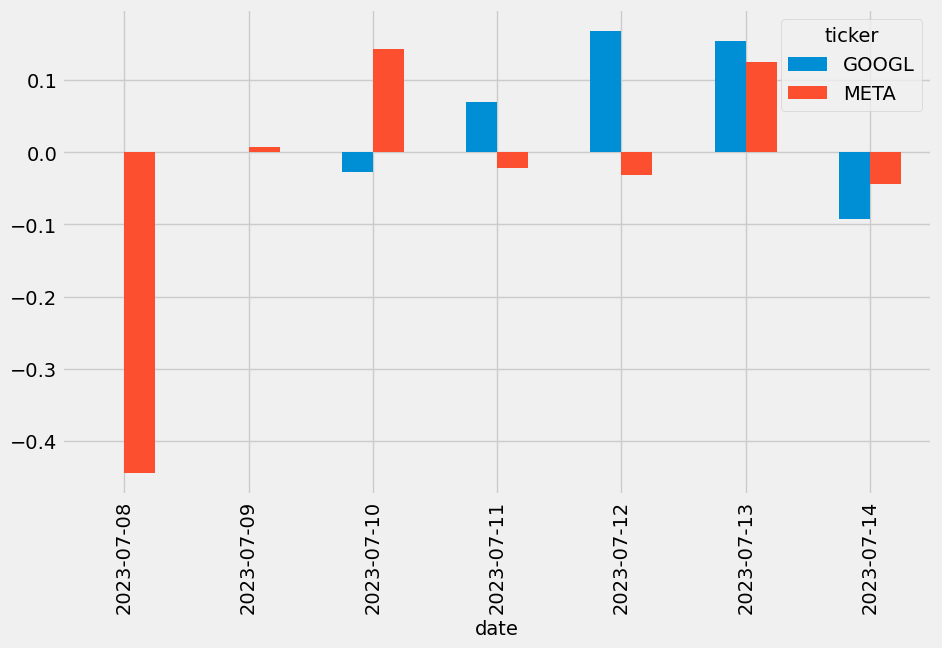

In [8]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

mean_c = scored_news.groupby(['date', 'ticker']).mean()

mean_c = mean_c.unstack('ticker')

mean_c = mean_c.xs("compound", axis="columns")

mean_c.plot.bar(figsize = (10, 6));

## 7. Remove duplicate news headlines  


In [9]:
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker'])


## 8. Sentiment on one single trading day (13/7/2023) and stock (META)


In [10]:
single_day = scored_news_clean.set_index(['ticker', 'date'])

single_day = single_day.xs('META')
single_day.index = pd.to_datetime(single_day.index)


single_day = single_day.loc["2023-07-13"]

single_day['time'] = pd.to_datetime(single_day['time']).dt.time

single_day = single_day.set_index('time')

single_day = single_day.sort_index()


In [11]:
single_day.head()

,headline,neg,neu,pos,compound
time,,,,,
00:00:00,Meta to release commercial AI model in effort ...,0.00,1.000,0.000,0.0000
05:20:00,3 Reasons Launching Threads Could Be a Horribl...,0.28,0.720,0.000,-0.5423
05:30:00,Metas Threads Now Has to Keep Its Millions of ...,0.00,0.787,0.213,0.4019
05:35:00,UK's New Online Safety Bill Applies to the Met...,0.00,0.629,0.371,0.6486
06:48:00,The Inflation Report Brought Good News. Why It...,0.00,0.775,0.225,0.4404


## 9. Visualize the single day


C:\Users\hiepm\AppData\Local\Temp\ipykernel_1464\2719790041.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  plot_day = single_day.drop(['compound', 'headline'], 1)


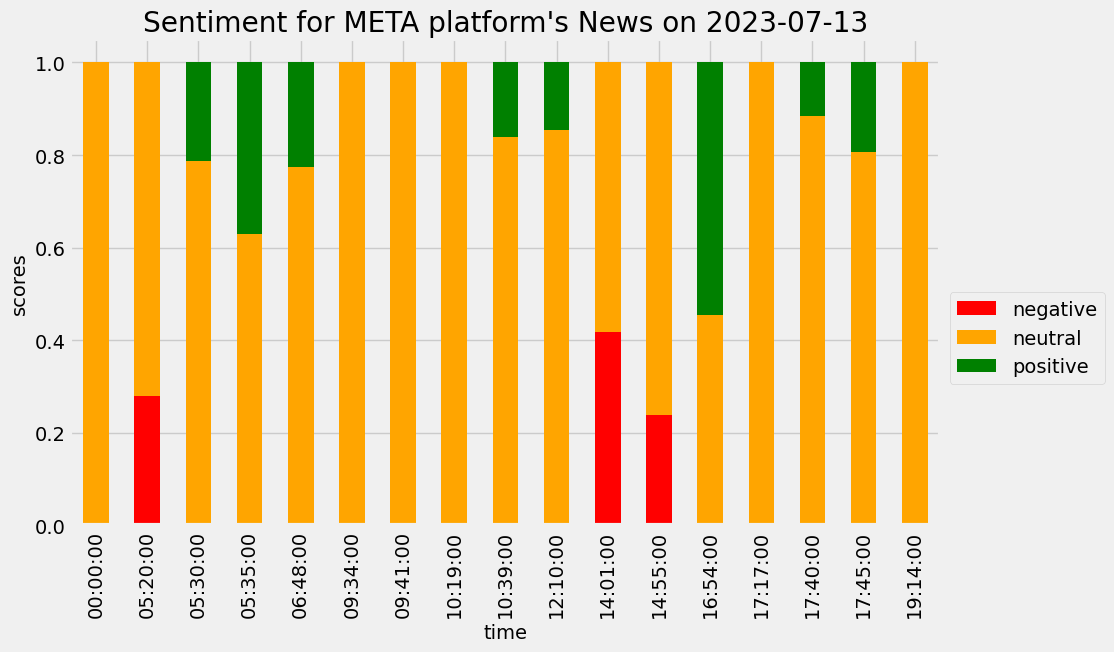

In [13]:
TITLE = "Sentiment for META platform's News on 2023-07-13"
COLORS = ["red","orange", "green"]

plot_day = single_day.drop(['compound', 'headline'], 1)

plot_day.columns = ['negative', 'neutral', 'positive']

plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");